In [1]:
%cd /home/stasvlad/Documents/hse/sberbank

/home/stasvlad/Documents/hse/sberbank


In [2]:
from utils import *

import folium
import geopandas as gpd
from shapely.geometry import Point

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])

train_df = encode(train_df)
test_df = encode(test_df)

all_df = pd.concat([train_df, test_df])

In [4]:
all_df.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,timestamp_year,timestamp_month,timestamp_day
id,,,,,,,,,,,,,,,,,,,,,
1,43.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,13,22,1,0,52,4,5850000.0,2011,8,20
2,34.0,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,15,29,1,10,66,14,6000000.0,2011,8,23
3,43.0,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,11,27,0,4,67,10,5700000.0,2011,8,27
4,89.0,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,4,4,0,0,26,3,13100000.0,2011,9,1
5,77.0,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,135,236,2,91,195,14,16331452.0,2011,9,5


Numerical outliers

In [5]:
all_df.loc[all_df['full_sq'] < 10, 'full_sq'] = np.nan
all_df.loc[all_df['full_sq'] > 250, 'full_sq'] /= 10
all_df.loc[all_df['full_sq'] > 1000, 'full_sq'] /= 100  # >1500 : np.nan

all_df.loc[all_df['life_sq'] < 7, 'life_sq'] = np.nan  # 5
all_df.loc[all_df['life_sq'] > 500, 'life_sq'] = np.nan

all_df.loc[all_df['floor'] == 0, 'floor'] = np.nan
all_df.loc[all_df['floor'] == 77, 'floor'] = np.nan

all_df.loc[all_df['max_floor'] == 0, 'max_floor'] = np.nan
all_df.loc[all_df['max_floor'] > 57, 'max_floor'] = np.nan

all_df.loc[all_df['build_year'] == 2, 'build_year'] = 2014
all_df.loc[all_df['build_year'] == 20, 'build_year'] = 2014
all_df.loc[all_df['build_year'] == 215, 'build_year'] = 2015
all_df.loc[all_df['build_year'] == 1691, 'build_year'] = 1961
all_df.loc[all_df['build_year'] == 4965, 'build_year'] = 1965
all_df.loc[all_df['build_year'] == 20052009, 'build_year'] = 2009
all_df.loc[all_df['build_year'] < 1850, 'build_year'] = np.nan
all_df.loc[all_df['build_year'] > 2020, 'build_year'] = np.nan

all_df.loc[all_df['num_room'] == 0, 'num_room'] = np.nan
all_df.loc[all_df['num_room'] > 15, 'num_room'] = np.nan

all_df.loc[all_df['kitch_sq'] > 500, 'kitch_sq'] = np.nan
all_df.loc[all_df['kitch_sq'] < 5, 'kitch_sq'] = np.nan  # 2

all_df.loc[all_df['state'] > 30, 'state'] = np.nan


Logical outliers

In [6]:
all_df.loc[all_df['life_sq'] > all_df['full_sq'], 'life_sq'] = np.nan
all_df.loc[all_df['floor'] > all_df['max_floor'], 'max_floor'] = np.nan
all_df.loc[all_df['kitch_sq'] >= all_df['life_sq'], 'kitch_sq'] = np.nan

Price outliers

In [7]:
bins = np.linspace(100000, 100_000_000, 1000)
bins = np.append(np.array(100), bins)

<AxesSubplot:>

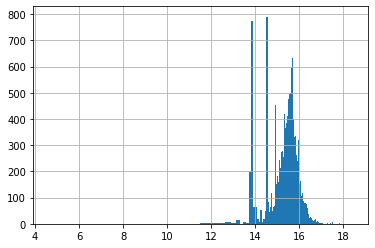

In [8]:
all_df['price_doc'].apply(np.log).hist(bins=np.log(bins))

In [67]:
idx_outliers_high = all_df[all_df['price_doc'] / all_df['full_sq'] > 600000].index  # 600000
idx_outliers_low = all_df[all_df['price_doc'] / all_df['full_sq'] < 30000].index
idx_outliers = idx_outliers_low.append(idx_outliers_high)

In [68]:
all_df.loc[idx_outliers].product_type.value_counts()

0.0    1073
1.0       6
Name: product_type, dtype: int64

<AxesSubplot:>

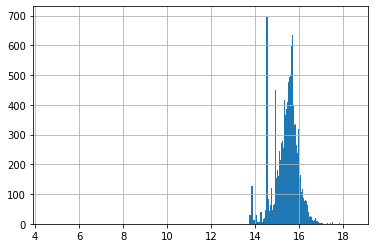

In [69]:
all_df.drop(idx_outliers, axis=0)['price_doc'].apply(np.log).hist(bins=np.log(bins))

In [70]:
all_df.drop(idx_outliers, axis=0, inplace=True)

<AxesSubplot:>

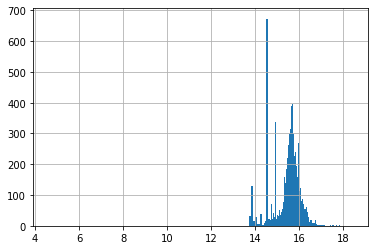

In [75]:
all_df[all_df['product_type'] == 0]['price_doc'].apply(np.log).hist(bins=np.log(bins))

In [85]:
idx_1M = all_df.loc[(all_df['product_type'] == 0) & (all_df['price_doc'] == 1_000_000)].index.values
idx_2M = all_df.loc[(all_df['product_type'] == 0) & (all_df['price_doc'] == 2_000_000)].index.values
idx_3M = all_df.loc[(all_df['product_type'] == 0) & (all_df['price_doc'] == 3_000_000)].index.values

<AxesSubplot:>

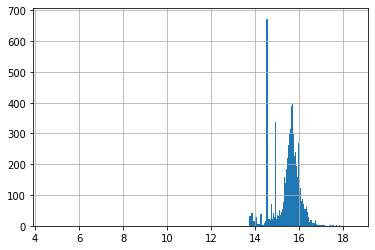

In [103]:
idx_1M_usampled = np.random.choice(idx_1M, size=int(0.7 * len(idx_1M)), replace=False)
all_df[all_df['product_type'] == 0]['price_doc'].drop(idx_1M_usampled, axis=0).apply(np.log).hist(bins=np.log(bins))

<AxesSubplot:>

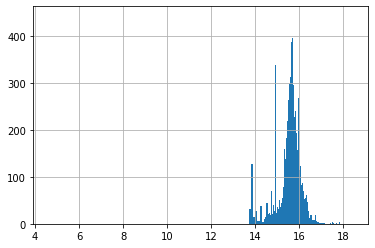

In [106]:
idx_2M_usampled = np.random.choice(idx_2M, size=int(0.95 * len(idx_2M)), replace=False)
all_df[all_df['product_type'] == 0]['price_doc'].drop(idx_2M_usampled, axis=0).apply(np.log).hist(bins=np.log(bins))

<AxesSubplot:>

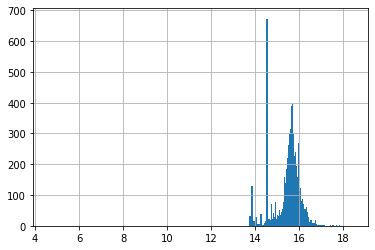

In [111]:
idx_3M_usampled = np.random.choice(idx_3M, size=int(0.8 * len(idx_3M)), replace=False)
all_df[all_df['product_type'] == 0]['price_doc'].drop(idx_3M_usampled, axis=0).apply(np.log).hist(bins=np.log(bins))

In [ ]:
test_df_nan = test_df[test_df['product_type'].isna()]
X_test_nan = test_df_nan.drop(['sub_area'], axis=1).copy()

In [ ]:
submission = pd.read_csv('data/sample_submission.csv', index_col='id')
pred_0 = model_0.predict(X_test_0)
pred_1 = model_1.predict(X_test_1)
pred_nan = model_1.predict(X_test_nan)

if len(pred_0[pred_0 < 0]) or len(pred_1[pred_1 < 0]) or len(pred_nan[pred_nan < 0]):
    print('WARNING: NEGATIVE PREDICTIONS')

In [ ]:
submission.loc[X_test_0.index, 'price_doc'] = pred_0
submission.loc[X_test_1.index, 'price_doc'] = pred_1
submission.loc[X_test_nan.index, 'price_doc'] = pred_nan
submission.to_csv('submission.csv', index='id')